In [1]:
import local_connectivity
from local_connectivity import make_tables, dist, connect_stats, plot
%reload_ext autoreload
%autoreload 2

In [2]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
from scipy.optimize import minimize
import warnings
from tqdm import tqdm

In [3]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [4]:
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
pre_root_ids = [864691135428608048]
pree = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pree.append(pre_grab)

In [6]:
np.unique(df.cell_type)

array(['23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6IT', '6P', 'BC',
       'BPC', 'MC', 'NGC', 'Unsure'], dtype=object)

In [127]:
pre = []
pre_df = df.query("cell_type == 'BC'").reset_index(drop=True)
for i in range(len(pre_df)):
    p = pre_df.iloc[[i]]
    pre.append(p)

In [128]:
len(pre)

45

In [129]:
main,syn,nonsyn = [],[],[]
badroots = []
for i in tqdm(range(len(pre))):
    try:
        m,s,n = make_tables.build_tables(client,pre[i])
        main.append(m)
        syn.append(s)
        nonsyn.append(n)
    except:
        badroots.append(pre[i])
        continue

100%|███████████████████████████████████████████| 45/45 [12:17<00:00, 16.39s/it]


In [130]:
len(badroots)

0

In [140]:
r_interval = 25
up = 200
threshold = 40
main_types,syn_types,nonsyn_types,f_type,s_type = make_tables.final_prep(main,syn,nonsyn,r_interval,up,threshold=None)
main_thresh,syn_thresh,nonsyn_thresh,main_types_thresh,syn_types_thresh,nonsyn_types_thresh,f_type_thresh,s_type_thresh = make_tables.final_prep(main,syn,nonsyn,r_interval,up,threshold)

100%|███████████████████████████████████████████| 45/45 [03:18<00:00,  4.41s/it]


## Log-Likelihood Function:

<h3> $$ l(\theta|\chi) = \displaystyle\sum_{i=1}^{n_{conn}} log(p(\theta|\chi_{conn_i})) + \displaystyle\sum_{j=1}^{n_{unc}} log(1 - p(\theta|\chi_{unc_j}))  $$

where $\chi_{conn}$ and $\chi_{unc}$ are the subset of experimental variables (in this case, intersomatic distance) for either connected or unconnected pairs.

### Probability function, based on a Gaussian function centered at zero distance (which won't work for some of the neurons...):

<h3> $$ p(\theta|\chi) = p_{max} e^{-\frac{d^{2}}{2\sigma^{2}}} $$ orrrrr $$ p(\theta|\chi) = p_{max} e^{-\frac{(d-\mu)^{2}}{2\sigma^{2}}} $$

where model parameters $\theta = \{p_{max},\sigma\}$ and experimental variable $\chi = \{d\}$ are

$p_{max}$ = peak connection probability,
    
$\sigma$ = distace constant of connection probability (changes with cell class), 
    
$d$ = lateral (radial) intersomatic distance of somatic pair, and

$\mu$ = center of probability function, if we want it at a position other than zero mirons away from the soma.

We will now select for the model parameters (peak connection probability and distance constant) which, assuming uniform priors (which honestly I'm not sure is accurate), make the observed distances between connected/unconnected neurons most probable. This is done by finding values for which the parameters maximize the above likelihood distribution over the parameter space.

Our parameter space $\Theta$ is fortunately constrained as $\Theta = \{\theta : p_{max} \in [0,1], \sigma \in [0,u]\}$ where $u$ is the upper distance limit of our sample. Luke's paper discusses how $\sigma$ is poorly constrained for low n, thus they use a fixed value at the subclass level:

- $\sigma$(Inh -> Inh) = 125 microns
- $\sigma$(Exc -> Exc) = 125 microns
- $\sigma$(Inh -> Exc) or (Exc -> Inh) = 95 microns

Luke based the Confidence Intervals (CIs) on the above log-likelihood function, and assumed it was asymptotically proportional to the $\chi^2$ distribution, where the upper and lower bounds were estimated with the 95th percentile of the $\chi^2$ distribution with one degree of freedom:

$$ 2l(p_{max,CI}|\chi) = 2l(p_{max}|\chi) - 3.84 $$

This will only work if pmax is NOT at its lower or upper limit, aka one of the parameters being at the edge of the parameter space.

This model will probably only be set identifiable - that is, learning the location of the true parameter may only be possible in a finite region of the parameter space. Otherwise, this may be partially identifiable, in which only pmax's true value can be learned

In [145]:
pmax,bin_ind,typemax = [],[],[]
for i in tqdm(range(len(pre))):
    pm,ind,tmax = connect_stats.pmax_type(s_type[i],f_type[i])
    pmax.append(pm)
    bin_ind.append(ind)
    typemax.append(tmax)

    
    # *** if threshold : ***
    
# pmax,bin_ind,typemax = [],[],[]
# for i in tqdm(range(len(pre))):
#     pm,ind,tmax = connect_stats.pmax_type(s_type_thresh[i],f_type_thresh[i])
#     pmax.append(pm)
#     bin_ind.append(ind)
#     typemax.append(tmax)

100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 740.16it/s]


In [146]:
mu = 0
results = []
for i in tqdm(range(len(pre))):
    rcell = []
    if pre[i].cell_type.values[0] == any(['BC','BPC','MC']):
        sigs = [95,95,95,95,95,95,125,125,125,95]
    else:
        sigs = [125,125,125,125,125,125,95,95,95,125]
    for j in range(len(syn_types[i])):
        init_guess = [pmax[i][j],sigs[j],mu]
        r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(40,200),(0,100)],
                     method='nelder-mead',args=(syn_types[i][j],nonsyn_types[i][j]))
        rcell.append(r)
    results.append(rcell)

    
    # *** if threshold : ***
    
# mu = 0
# results = []
# for i in tqdm(range(len(pre))):
#     rcell = []
#     if pre[i].cell_type.values[0] == any(['BC','BPC','MC']):
#         sigs = [95,95,95,95,95,95,125,125,125,95]
#     else:
#         sigs = [125,125,125,125,125,125,95,95,95,125]
#     for j in range(len(syn_types_thresh[i])):
#         init_guess = [pmax[i][j],sigs[j],mu]
#         r = minimize(fun=connect_stats.log_likelihood,x0=init_guess,bounds=[(0,1.),(40,200),(0,100)],
#                      method='nelder-mead',args=(syn_types_thresh[i][j],nonsyn_types_thresh[i][j]))
#         rcell.append(r)
#     results.append(rcell)

100%|███████████████████████████████████████████| 45/45 [04:28<00:00,  5.96s/it]


In [147]:
pmax,sigs,moo = [],[],[]
for j in range(len(results[i])):
    pp,mm,ss = [],[],[]
    for i in range(len(results)):
        pp.append(results[i][j].x[0])
        ss.append(results[i][j].x[1])
        mm.append(results[i][j].x[2])
    pmax.append(pp)
    moo.append(mm)
    sigs.append(ss)

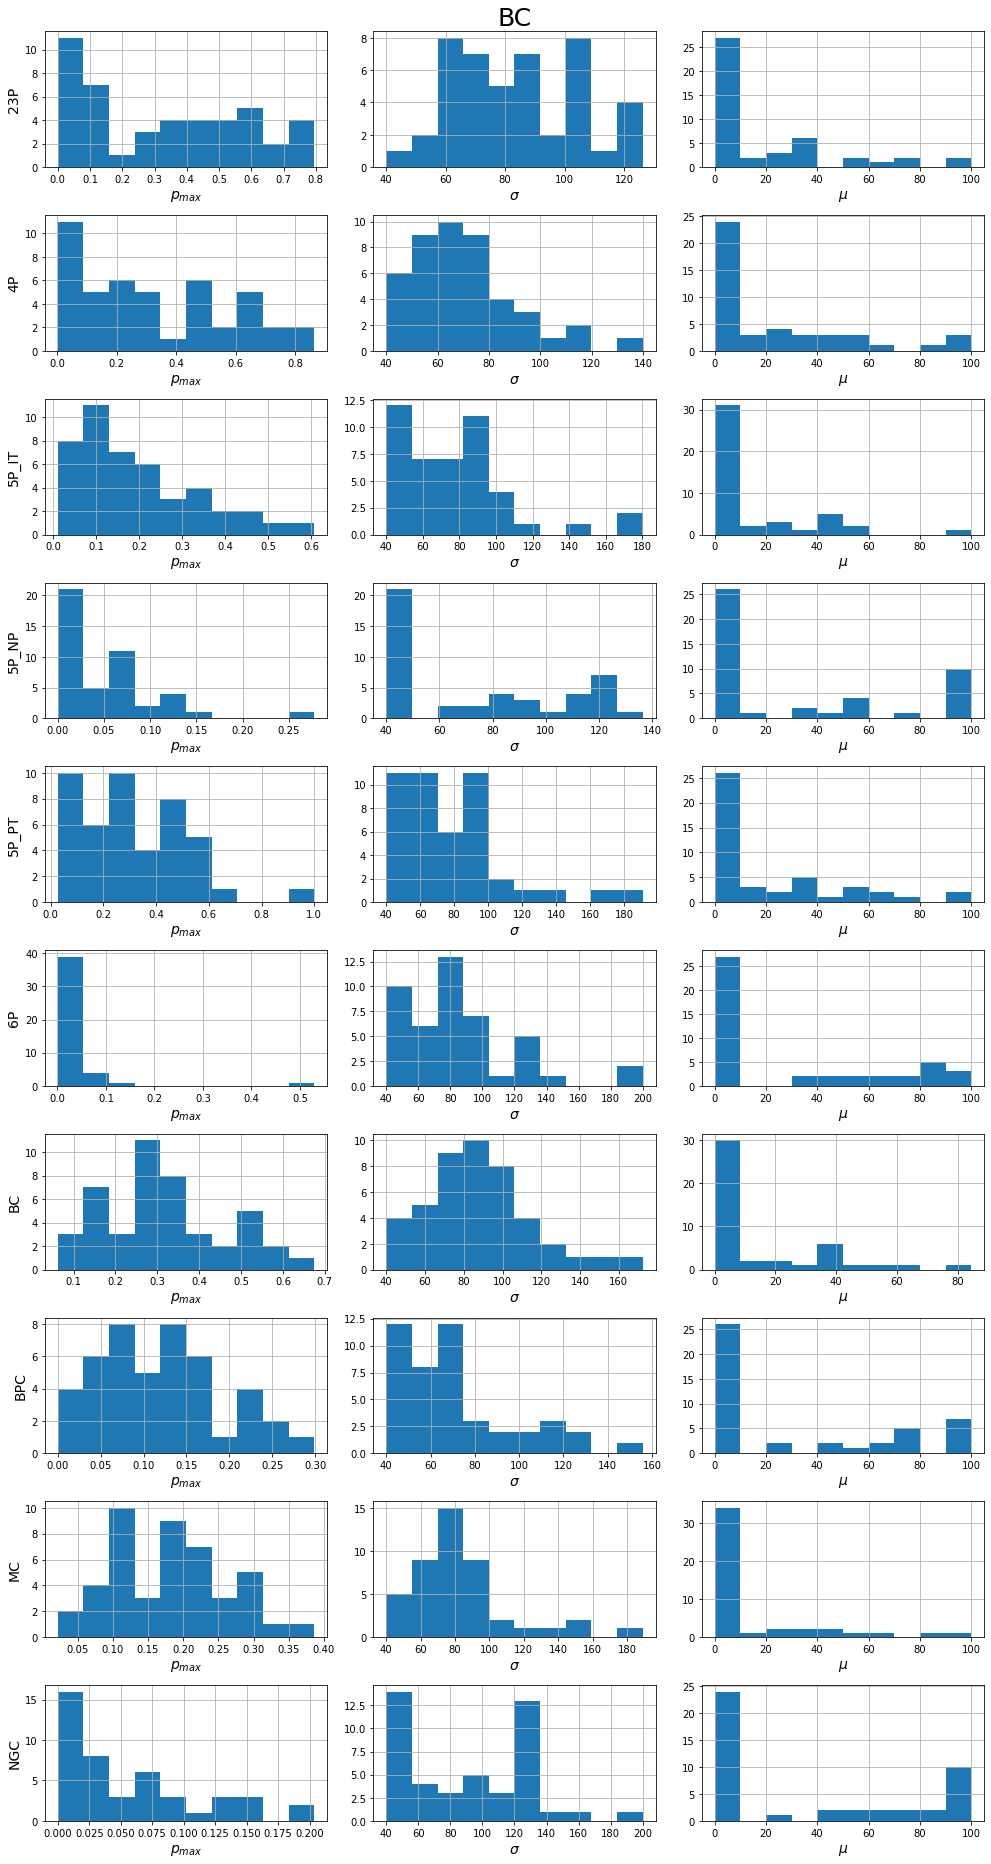

In [148]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(len(pmax),3)
fig.set_size_inches(14,26)

for i in range(len(pmax)):
    ax[i,0].hist(pmax[i])
    ax[i,0].set_xlabel(r'$p_{max}$', fontsize=14)
    ax[i,0].set_ylabel(np.unique(main[0].cell_type)[i], fontsize=14)
    ax[i,0].grid()

    ax[i,1].hist(sigs[i])
    ax[i,1].set_xlabel(r'$\sigma$', fontsize=14)
    ax[0,1].set_title(pre[0].cell_type[0],fontsize=25)
    ax[i,1].grid()
    
    ax[i,2].hist(moo[i])
    ax[i,2].set_xlabel(r'$\mu$', fontsize=14)
    ax[i,2].grid()

fig.tight_layout()
fig.savefig('./plots/{0:s}/MLE-{1:s}-{2:s}bin.pdf'.format(str(pre[0].cell_type[0]),str(up),str(r_interval)))
#fig.savefig('./plots/{0:s}/MLE-{1:s}-{2:s}bin-{3:s}thresh.pdf'.format(str(pre[0].cell_type[0]),str(up),str(r_interval),str(threshold)))